In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [ ]:
import pandas as pd

# File path of the dataset
path = "/content/dataset/cnn_dailymail/train.csv"

# Load the dataset
df = pd.read_csv(path)

# Print columns and shape for verification
print("Columns in the dataset:", df.columns)
print("Shape of the dataset:", df.shape)

# Split the dataset into two equal parts
split_index = len(df) // 20
train_part1 = df.iloc[:split_index]  # First half
train_part2 = df.iloc[split_index:]  # Second half

# Save the splits to new CSV files
train_part1.to_csv("/content/dataset/cnn_dailymail/train_part1.csv", index=False)
train_part2.to_csv("/content/dataset/cnn_dailymail/train_part2.csv", index=False)

print("Dataset has been split into two parts:")
print(f"Part 1: {train_part1.shape}")
print(f"Part 2: {train_part2.shape}")

Columns in the dataset: Index(['id', 'article', 'highlights'], dtype='object')
Shape of the dataset: (287113, 3)
Dataset has been split into two parts:
Part 1: (14355, 3)
Part 2: (272758, 3)


In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import cudf
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import re

# Map POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Preprocess each article
def preprocess_text(text):
    if pd.isna(text) or not text.strip():  # Handle empty or NaN
        return []
    sentences = sent_tokenize(text)
    # Initialize tools
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))

    # Normalize text: lowercase and remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text).lower()

    # Split into sentences
    sentences = sent_tokenize(text)

    # Process each sentence
    processed_sentences = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        pos_tags = pos_tag(words)
        processed_words = [
            lemmatizer.lemmatize(word, get_wordnet_pos(pos))
            for word, pos in pos_tags
            if word not in stop_words and word.isalnum()
        ]
        if processed_words:
            processed_sentences.append(" ".join(processed_words))

    return processed_sentences

# Preprocess CSV file
def preprocess_csv(file_path, text_column):
    # Read CSV with cuDF
    df = cudf.read_csv(file_path)

    # Convert text column to pandas for processing
    text_series = df[text_column].to_pandas()

    # Apply preprocessing with tqdm progress bar
    tqdm.pandas()
    processed_text = text_series.progress_apply(preprocess_text)

    # Convert list of sentences into a string (so it can be saved in CSV)
    df["processed_text"] = processed_text.apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

    return df

# File path and column to preprocess
file_path = "/content/dataset/cnn_dailymail/train_part1.csv"
text_column = "article"

# Process and display results
processed_df = preprocess_csv(file_path, text_column)

# Save the preprocessed DataFrame (converted processed text to string)
processed_df.to_csv("/content/dataset/cnn_dailymail/train_part1_preprocessed.csv", index=False)
print("Preprocessed DataFrame:")
print(processed_df.head())


100%|██████████| 14355/14355 [06:49<00:00, 35.02it/s]


Preprocessed DataFrame:
                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  \
0  Bishop John Folda, of North Dakota, is taking ...   
1  Criminal complaint: Cop used his role to help ...   
2  Craig Eccleston-Todd, 27, had drunk at least t...   
3  Nina dos Santos says Europe must be ready to a...   
4  Fleetwood top of League One after 2-0 win at S...   

                   

In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
import networkx as nx

# Function to vectorize sentences into TF-IDF features
def vectorize_sentences(sentences):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(sentences)

# Function to extract central words based on co-occurrence graph and PageRank
def extract_central_words_with_graph(word_list):
    G = nx.Graph()

    # Add edges based on word co-occurrence
    for i, word in enumerate(word_list[:-1]):
        for j in range(i + 1, min(len(word_list), i + 5)):  # Co-occurrence window of 5
            G.add_edge(word, word_list[j])

    # Compute centrality using PageRank
    centrality_scores = nx.pagerank(G)
    central_words = sorted(centrality_scores, key=centrality_scores.get, reverse=True)[:10]
    return central_words

# Rank sentences by clustering and central word importance
def rank_sentences_by_clustering_and_central_words(sentences, tfidf_matrix, central_words, top_n_sentences=5):
    # Compute the cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Convert cosine similarity to distance matrix (1 - cosine_sim)
    distance_matrix = 1 - cosine_sim  # Convert similarity to distance

    n_clusters = min(len(sentences), top_n_sentences)

    # Perform Agglomerative Clustering on the distance matrix (fixing affinity issues)
    clustering_model = AgglomerativeClustering(n_clusters=n_clusters, linkage='average')
    clusters = clustering_model.fit_predict(distance_matrix)

    # Rank sentences within each cluster based on central words
    ranked_sentences = []
    for cluster in range(n_clusters):
        cluster_indices = [i for i, label in enumerate(clusters) if label == cluster]
        cluster_sentences = [(idx, sentences[idx]) for idx in cluster_indices]

        # Rank sentences in the cluster by central word frequency
        ranked_cluster_sentences = sorted(
            cluster_sentences,
            key=lambda x: sum(1 for word in word_tokenize(x[1].lower()) if word in central_words),
            reverse=True
        )

        ranked_sentences.extend(ranked_cluster_sentences[:max(1, top_n_sentences // n_clusters)])

    # Sort the ranked sentences by their original order
    ranked_sentences_sorted = sorted(ranked_sentences, key=lambda x: x[0])
    return [sentence for _, sentence in ranked_sentences_sorted]

# Function to perform extractive summarization
def extractive_summary(input_text, top_n_sentences=5):
    # Tokenize the input text into sentences
    sentences = nltk.sent_tokenize(input_text)

    # Convert sentences to TF-IDF features
    tfidf_matrix = vectorize_sentences(sentences)

    # Extract central words from the text using a co-occurrence graph
    word_list = [word.lower() for sentence in sentences for word in nltk.word_tokenize(sentence)]
    central_words = extract_central_words_with_graph(word_list)

    # Rank sentences based on their importance and centrality of words
    ranked_sentences = rank_sentences_by_clustering_and_central_words(
        sentences, tfidf_matrix, central_words, top_n_sentences
    )

    return "\n".join(ranked_sentences)

# Load the CNN/Daily Mail dataset
file_path = "/content/dataset/cnn_dailymail/train_part1_preprocessed.csv"  # Adjust this path to your dataset
df = pd.read_csv(file_path)

# Example: Process articles and generate extractive summaries
df['extractive_summary'] = df['article'].apply(lambda x: extractive_summary(x, top_n_sentences=5))

# Save the summarized dataset to a new CSV
df[['id','article','highlights' ,'extractive_summary']].to_csv("/content/dataset/cnn_dailymail/summarized_cnn_dailymail.csv", index=False)

# Example to display the first 5 rows of the summaries
print(df[['id','article','highlights', 'extractive_summary']].head())


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                                             article  \
0  By . Associated Press . PUBLISHED: . 14:11 EST...   
1  (CNN) -- Ralph Mata was an internal affairs li...   
2  A drunk driver who killed a young woman in a h...   
3  (CNN) -- With a breezy sweep of his pen Presid...   
4  Fleetwood are the only team still to have a 10...   

                                          highlights  \
0  Bishop John Folda, of North Dakota, is taking ...   
1  Criminal complaint: Cop used his role to help ...   
2  Craig Eccleston-Todd, 27, had drunk at least t...   
3  Nina dos Santos says Europe must be ready to a...   
4  Fleetwood top of League One after 2-0 win at S...   

                                  extractiv

In [ ]:
from rouge_score import rouge_scorer
import pandas as pd

# Load the dataset with summaries
file_path = "/content/dataset/cnn_dailymail/summarized_cnn_dailymail.csv"
df = pd.read_csv(file_path)

# Function to compute ROUGE scores
def compute_rouge(reference, summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, summary)
    return scores

# Apply ROUGE evaluation on the dataset
rouge_scores = df.apply(lambda row: compute_rouge(str(row['highlights']), str(row['extractive_summary'])), axis=1)

# Calculate mean ROUGE scores
rouge1_precision = np.mean([score['rouge1'].precision for score in rouge_scores])
rouge1_recall = np.mean([score['rouge1'].recall for score in rouge_scores])
rouge1_fmeasure = np.mean([score['rouge1'].fmeasure for score in rouge_scores])

rouge2_precision = np.mean([score['rouge2'].precision for score in rouge_scores])
rouge2_recall = np.mean([score['rouge2'].recall for score in rouge_scores])
rouge2_fmeasure = np.mean([score['rouge2'].fmeasure for score in rouge_scores])

rougeL_precision = np.mean([score['rougeL'].precision for score in rouge_scores])
rougeL_recall = np.mean([score['rougeL'].recall for score in rouge_scores])
rougeL_fmeasure = np.mean([score['rougeL'].fmeasure for score in rouge_scores])

# Output the average ROUGE scores
average_rouge_scores = {
    'rouge1_precision': rouge1_precision,
    'rouge1_recall': rouge1_recall,
    'rouge1_fmeasure': rouge1_fmeasure,
    'rouge2_precision': rouge2_precision,
    'rouge2_recall': rouge2_recall,
    'rouge2_fmeasure': rouge2_fmeasure,
    'rougeL_precision': rougeL_precision,
    'rougeL_recall': rougeL_recall,
    'rougeL_fmeasure': rougeL_fmeasure
}

# Print overall average ROUGE scores
print("Average ROUGE Scores for the dataset:")
for metric, score in average_rouge_scores.items():
    print(f"{metric}: {score:.4f}")

# Save the full dataset with ROUGE scores
df = pd.concat([df, pd.DataFrame(rouge_scores.tolist())], axis=1)
df.to_csv("/content/dataset/cnn_dailymail/rouge_scores.csv", index=False)


Average ROUGE Scores for the dataset:
rouge1_precision: 0.2037
rouge1_recall: 0.4818
rouge1_fmeasure: 0.2759
rouge2_precision: 0.0663
rouge2_recall: 0.1596
rouge2_fmeasure: 0.0902
rougeL_precision: 0.1245
rougeL_recall: 0.3000
rougeL_fmeasure: 0.1695


In [ ]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd

# Load the dataset with extractive summaries
df = pd.read_csv("/content/dataset/cnn_dailymail/summarized_cnn_dailymail.csv")

# Ensure the extractive summaries are clean and not NaN
df = df.dropna(subset=['extractive_summary'])

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the splits to new CSV files
train_df.to_csv("/content/dataset/cnn_dailymail/train_t5.csv", index=False)
test_df.to_csv("/content/dataset/cnn_dailymail/test_t5.csv", index=False)

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CNNDailyMailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        extractive_summary = self.dataframe.iloc[idx]['extractive_summary']
        highlights = self.dataframe.iloc[idx]['highlights']

        # Tokenize the input and target
        input_encoding = self.tokenizer(
            extractive_summary,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            highlights,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': target_encoding['input_ids'].squeeze()
        }

# Create the datasets
train_dataset = CNNDailyMailDataset(train_df, tokenizer)
test_dataset = CNNDailyMailDataset(test_df, tokenizer)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1436/1436 [16:02<00:00,  1.49it/s]


Epoch 1/3, Loss: 0.8068325471620705


100%|██████████| 1436/1436 [16:09<00:00,  1.48it/s]


Epoch 2/3, Loss: 0.4634995281820842


100%|██████████| 1436/1436 [16:11<00:00,  1.48it/s]


Epoch 3/3, Loss: 0.45293521912234075


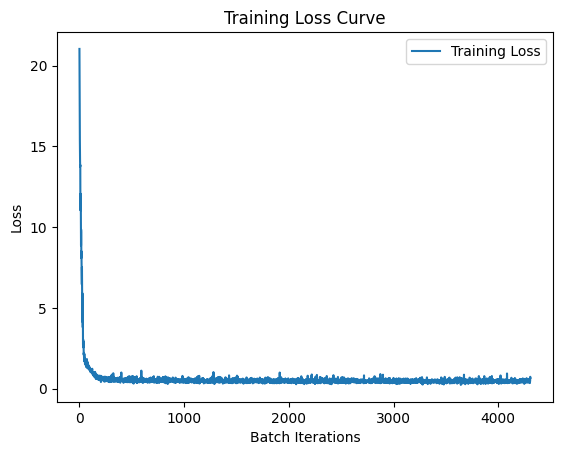

In [ ]:
import torch
from transformers import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        losses.append(loss.item())  # Store the loss for each batch

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")

# Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Batch Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()


100%|██████████| 359/359 [01:26<00:00,  4.14it/s]

Test Loss: 0.42145912693735615


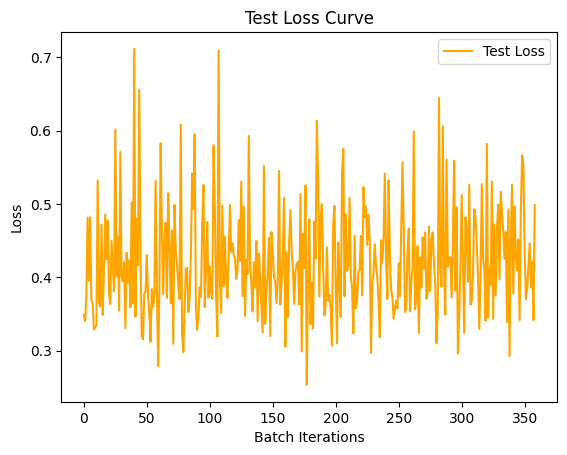

In [ ]:

# Evaluation loop
model.eval()
test_losses = []
total_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        test_losses.append(loss.item())

avg_loss = total_loss / len(test_loader)
print(f"Test Loss: {avg_loss}")

# Plot the test loss curve
plt.plot(test_losses, label='Test Loss', color='orange')
plt.xlabel('Batch Iterations')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()
plt.show()

In [ ]:
# Function to generate summaries
def generate_summary(text, model, tokenizer, max_length=512):
    model.eval()
    input_ids = tokenizer.encode("summarize: " + text, return_tensors="pt",
                                 max_length=max_length, truncation=True).to(device)
    summary_ids = model.generate(input_ids, max_length=max_length, num_beams=4,
                                 length_penalty=2.0, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Generate summaries for all test samples
generated_summaries = []
for i in tqdm(range(len(test_df)), desc="Generating Summaries"):
    input_text = test_df.iloc[i]['extractive_summary']
    summary = generate_summary(input_text, model, tokenizer)
    generated_summaries.append(summary)

# Save generated summaries
test_df['generated_summary'] = generated_summaries
test_df.to_csv("/content/dataset/cnn_dailymail/test_with_summaries.csv", index=False)


Generating Summaries: 100%|██████████| 2871/2871 [33:35<00:00,  1.42it/s]


In [ ]:
# Save model and tokenizer
model.save_pretrained("/content/t5_summarization_model")
tokenizer.save_pretrained("/content/t5_summarization_model")


NameError: name 'model' is not defined

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model = T5ForConditionalGeneration.from_pretrained("/content/t5_summarization_model")
tokenizer = T5Tokenizer.from_pretrained("/content/t5_summarization_model")

print("Model and tokenizer loaded successfully!")


In [ ]:
!pip install rouge-score


In [ ]:
import pandas as pd
from tqdm import tqdm
from rouge_score import rouge_scorer

# Load the dataset with generated summaries
df = pd.read_csv("/content/dataset/cnn_dailymail/test_with_summaries.csv")

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store precision, recall, and f1-scores separately
rouge1_p, rouge1_r, rouge1_f = [], [], []
rouge2_p, rouge2_r, rouge2_f = [], [], []
rougeL_p, rougeL_r, rougeL_f = [], [], []

# Compute ROUGE scores for each sample
for i in tqdm(range(len(df)), desc="Calculating ROUGE Scores"):
    reference_summary = df.iloc[i]['highlights']
    generated_summary = df.iloc[i]['generated_summary']

    # Compute ROUGE scores
    scores = scorer.score(reference_summary, generated_summary)

    # Append scores
    rouge1_p.append(scores['rouge1'].precision)
    rouge1_r.append(scores['rouge1'].recall)
    rouge1_f.append(scores['rouge1'].fmeasure)

    rouge2_p.append(scores['rouge2'].precision)
    rouge2_r.append(scores['rouge2'].recall)
    rouge2_f.append(scores['rouge2'].fmeasure)

    rougeL_p.append(scores['rougeL'].precision)
    rougeL_r.append(scores['rougeL'].recall)
    rougeL_f.append(scores['rougeL'].fmeasure)

# Compute mean ROUGE scores
mean_rouge_scores = {
    "ROUGE-1": {
        "Precision": sum(rouge1_p) / len(rouge1_p),
        "Recall": sum(rouge1_r) / len(rouge1_r),
        "F1-score": sum(rouge1_f) / len(rouge1_f),
    },
    "ROUGE-2": {
        "Precision": sum(rouge2_p) / len(rouge2_p),
        "Recall": sum(rouge2_r) / len(rouge2_r),
        "F1-score": sum(rouge2_f) / len(rouge2_f),
    },
    "ROUGE-L": {
        "Precision": sum(rougeL_p) / len(rougeL_p),
        "Recall": sum(rougeL_r) / len(rougeL_r),
        "F1-score": sum(rougeL_f) / len(rougeL_f),
    },
}

# Print results
print("\nMean ROUGE Scores (Precision, Recall, F1-score):")
for key, value in mean_rouge_scores.items():
    print(f"{key}:")
    print(f"  Precision = {value['Precision']:.4f}")
    print(f"  Recall    = {value['Recall']:.4f}")
    print(f"  F1-score  = {value['F1-score']:.4f}\n")


Calculating ROUGE Scores: 100%|██████████| 2871/2871 [00:09<00:00, 313.64it/s]


Mean ROUGE Scores (Precision, Recall, F1-score):
ROUGE-1:
  Precision = 0.3422
  Recall    = 0.2383
  F1-score  = 0.2681

ROUGE-2:
  Precision = 0.1188
  Recall    = 0.0820
  F1-score  = 0.0923

ROUGE-L:
  Precision = 0.2443
  Recall    = 0.1707
  F1-score  = 0.1916



In [ ]:
import pandas as pd

# Load the dataset with extractive summaries
df = pd.read_csv("/content/dataset/cnn_dailymail/summarized_cnn_dailymail.csv")

# Ensure the extractive summaries are clean and not NaN
df = df.dropna(subset=['extractive_summary'])

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Save the splits to new CSV files
train_df.to_csv("/content/dataset/cnn_dailymail/Bart.csv", index=False)
test_df.to_csv("/content/dataset/cnn_dailymail/Bart.csv", index=False)

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load the BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class CNNDailyMailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        article = self.dataframe.iloc[idx]['extractive_summary']
        summary = self.dataframe.iloc[idx]['highlights']

        # Tokenize input and target
        inputs = self.tokenizer(
            article,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        targets = self.tokenizer(
            summary,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": targets["input_ids"].squeeze()
        }

# Create dataset
train_dataset = CNNDailyMailDataset(train_df, tokenizer)
test_dataset = CNNDailyMailDataset(test_df, tokenizer)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [ ]:
from transformers import AdamW
from tqdm import tqdm

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Training loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}")


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 1436/1436 [29:20<00:00,  1.23s/it]


Epoch 1/3, Loss: 0.6357213481430556


100%|██████████| 1436/1436 [29:14<00:00,  1.22s/it]


Epoch 2/3, Loss: 0.3806026197015243


100%|██████████| 1436/1436 [29:14<00:00,  1.22s/it]

Epoch 3/3, Loss: 0.3521726029746048


In [ ]:
model.eval()
total_loss = 0
with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f"Test Loss: {avg_loss}")


100%|██████████| 359/359 [02:13<00:00,  2.70it/s]

Test Loss: 0.373498382840648


In [ ]:
def generate_summary(text, model, tokenizer, max_length=512):
    model.eval()
    input_ids = tokenizer.encode(text, return_tensors="pt", max_length=max_length, truncation=True).to(device)

    summary_ids = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        length_penalty=2.0,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Generate summaries for all test samples
generated_summaries = []
for i in tqdm(range(len(test_df)), desc="Generating Summaries"):
    input_text = test_df.iloc[i]['extractive_summary']
    summary = generate_summary(input_text, model, tokenizer)
    generated_summaries.append(summary)

# Save the generated summaries
test_df['generated_summary'] = generated_summaries
test_df.to_csv("/content/dataset/cnn_dailymail/bart_test_with_summaries.csv", index=False)


Generating Summaries: 100%|██████████| 2871/2871 [30:02<00:00,  1.59it/s]


In [ ]:
# Save model and tokenizer
model.save_pretrained("/content/bart_summarization_model")
tokenizer.save_pretrained("/content/bart_summarization_model")
print("Model and tokenizer saved successfully!")

# Load the saved model later
from transformers import BartForConditionalGeneration, BartTokenizer

model = BartForConditionalGeneration.from_pretrained("/content/bart_summarization_model")
tokenizer = BartTokenizer.from_pretrained("/content/bart_summarization_model")
print("Model and tokenizer loaded successfully!")


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Model and tokenizer saved successfully!
Model and tokenizer loaded successfully!


In [ ]:
import pandas as pd
from tqdm import tqdm
from rouge_score import rouge_scorer

# Load the dataset with generated summaries
df = pd.read_csv("/content/dataset/cnn_dailymail/bart_test_with_summaries.csv")

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Lists to store precision, recall, and f1-scores separately
rouge1_p, rouge1_r, rouge1_f = [], [], []
rouge2_p, rouge2_r, rouge2_f = [], [], []
rougeL_p, rougeL_r, rougeL_f = [], [], []

# Compute ROUGE scores for each sample
for i in tqdm(range(len(df)), desc="Calculating ROUGE Scores"):
    reference_summary = df.iloc[i]['highlights']
    generated_summary = df.iloc[i]['generated_summary']

    # Compute ROUGE scores
    scores = scorer.score(reference_summary, generated_summary)

    # Append scores
    rouge1_p.append(scores['rouge1'].precision)
    rouge1_r.append(scores['rouge1'].recall)
    rouge1_f.append(scores['rouge1'].fmeasure)

    rouge2_p.append(scores['rouge2'].precision)
    rouge2_r.append(scores['rouge2'].recall)
    rouge2_f.append(scores['rouge2'].fmeasure)

    rougeL_p.append(scores['rougeL'].precision)
    rougeL_r.append(scores['rougeL'].recall)
    rougeL_f.append(scores['rougeL'].fmeasure)

# Compute mean ROUGE scores
mean_rouge_scores = {
    "ROUGE-1": {
        "Precision": sum(rouge1_p) / len(rouge1_p),
        "Recall": sum(rouge1_r) / len(rouge1_r),
        "F1-score": sum(rouge1_f) / len(rouge1_f),
    },
    "ROUGE-2": {
        "Precision": sum(rouge2_p) / len(rouge2_p),
        "Recall": sum(rouge2_r) / len(rouge2_r),
        "F1-score": sum(rouge2_f) / len(rouge2_f),
    },
    "ROUGE-L": {
        "Precision": sum(rougeL_p) / len(rougeL_p),
        "Recall": sum(rougeL_r) / len(rougeL_r),
        "F1-score": sum(rougeL_f) / len(rougeL_f),
    },
}

# Print results
print("\nMean ROUGE Scores (Precision, Recall, F1-score):")
for key, value in mean_rouge_scores.items():
    print(f"{key}:")
    print(f"  Precision = {value['Precision']:.4f}")
    print(f"  Recall    = {value['Recall']:.4f}")
    print(f"  F1-score  = {value['F1-score']:.4f}\n")


Calculating ROUGE Scores: 100%|██████████| 2871/2871 [00:15<00:00, 180.25it/s]


Mean ROUGE Scores (Precision, Recall, F1-score):
ROUGE-1:
  Precision = 0.3218
  Recall    = 0.3194
  F1-score  = 0.3076

ROUGE-2:
  Precision = 0.1078
  Recall    = 0.1070
  F1-score  = 0.1027

ROUGE-L:
  Precision = 0.2138
  Recall    = 0.2147
  F1-score  = 0.2054



In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
import networkx as nx
from tqdm import tqdm

# Download necessary NLTK resources
nltk.download('punkt')

# Function to vectorize sentences into TF-IDF features
def vectorize_sentences(sentences):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(sentences)

# Function to extract central words based on co-occurrence graph and PageRank
def extract_central_words_with_graph(word_list):
    G = nx.Graph()

    # Add edges based on word co-occurrence
    for i, word in enumerate(word_list[:-1]):
        for j in range(i + 1, min(len(word_list), i + 5)):  # Co-occurrence window of 5
            G.add_edge(word, word_list[j])

    # Compute centrality using PageRank
    centrality_scores = nx.pagerank(G)
    central_words = sorted(centrality_scores, key=centrality_scores.get, reverse=True)[:10]
    return central_words

# Function to find optimal k for KMeans using Silhouette Score
def find_optimal_k_using_silhouette(tfidf_matrix, max_k=10):
    best_k = 2  # Initialize with a default minimum value
    best_score = -1  # Initialize with a very low silhouette score

    for k in range(2, min(max_k + 1, tfidf_matrix.shape[0])):  # Iterate through possible values of k
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tfidf_matrix)
        labels = kmeans.predict(tfidf_matrix)

        # Calculate the Silhouette Score
        silhouette_avg = silhouette_score(tfidf_matrix, labels)

        # If the score is better than previous, update best_k
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_k = k

    return best_k

# Rank sentences by central word importance
def rank_sentences_by_similarity_and_central_words(sentences, tfidf_matrix, central_words, top_n_sentences=5, n_clusters=5):
    # Ensure n_clusters is not greater than the number of sentences
    n_clusters = min(n_clusters, len(sentences))

    # Compute the cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Use the cosine similarity as the distance metric for clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(1 - cosine_sim)  # Using 1 - cosine similarity for distance

    # Rank all sentences based on central words
    sentence_scores = []
    for idx, sentence in enumerate(sentences):
        central_word_count = sum(1 for word in nltk.word_tokenize(sentence.lower()) if word in central_words)
        sentence_scores.append((idx, sentence, central_word_count))

    # Sort sentences by their central word count (importance)
    ranked_sentences = sorted(sentence_scores, key=lambda x: x[2], reverse=True)

    # Select top_n_sentences
    top_sentences = ranked_sentences[:top_n_sentences]

    # Sort selected top sentences by their original order (preserving text flow)
    top_sentences_sorted = sorted(top_sentences, key=lambda x: x[0])

    return [sentence for _, sentence, _ in top_sentences_sorted]

# Function to perform extractive summarization with optimal k selection
def extractive_summary_with_optimal_k(input_text, top_n_sentences=5, max_k=10):
    # Tokenize the input text into sentences
    sentences = nltk.sent_tokenize(input_text)

    if len(sentences) <= 1:  # Handle edge case with very short articles
        return input_text

    # Convert sentences to TF-IDF features
    tfidf_matrix = vectorize_sentences(sentences)

    # Extract central words from the text using a co-occurrence graph
    word_list = [word.lower() for sentence in sentences for word in nltk.word_tokenize(sentence)]
    central_words = extract_central_words_with_graph(word_list)

    # Find the optimal number of clusters for the sentences using Silhouette Score
    optimal_k = find_optimal_k_using_silhouette(tfidf_matrix, max_k)

    # Rank sentences based on their importance and centrality of words
    ranked_sentences = rank_sentences_by_similarity_and_central_words(
        sentences, tfidf_matrix, central_words, top_n_sentences, optimal_k
    )

    return "\n".join(ranked_sentences)

# Load the CNN/Daily Mail dataset
file_path = "/content/dataset/cnn_dailymail/train_part1_preprocessed.csv"  # Adjust this path to your dataset
df = pd.read_csv(file_path)

# Process articles and generate extractive summaries with optimal k
# Wrap the apply function in tqdm to track progress across the entire dataset
df['kmeans_extractive_summary'] = df['article'].progress_apply(
    lambda x: extractive_summary_with_optimal_k(x, top_n_sentences=5, max_k=10)
)

# Save the summarized dataset to a new CSV
df[['id', 'kmeans_extractive_summary']].to_csv(
    "/content/dataset/cnn_dailymail/summarized_cnn_dailymail_kmeans_silhouette.csv", index=False
)

# Example: Display the first 5 rows of the summaries
print(df[['id', 'kmeans_extractive_summary']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
 64%|██████▍   | 9187/14355 [14:11<06:53, 12.50it/s]/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|██████████| 14355/14355 [21:56<00:00, 10.90it/s]


                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                           kmeans_extractive_summary  
0  The bishop of the Fargo Catholic Diocese in No...  
1  A criminal complaint unsealed in U.S. District...  
2  As he was reading or replying to it, he veered...  
3  (CNN) -- With a breezy sweep of his pen Presid...  
4  Fleetwood are the only team still to have a 10...  


In [ ]:
import pandas as pd
from rouge_score import rouge_scorer
import nltk

# Ensure nltk downloads
nltk.download('punkt')

# Function to calculate ROUGE scores (Precision, Recall, F-Measure)
def calculate_rouge_scores(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)

    # ROUGE Precision, Recall, F-Measure for each metric
    rouge_scores = {
        "rouge1_precision": scores['rouge1'].precision,
        "rouge1_recall": scores['rouge1'].recall,
        "rouge1_fmeasure": scores['rouge1'].fmeasure,
        "rouge2_precision": scores['rouge2'].precision,
        "rouge2_recall": scores['rouge2'].recall,
        "rouge2_fmeasure": scores['rouge2'].fmeasure,
        "rougeL_precision": scores['rougeL'].precision,
        "rougeL_recall": scores['rougeL'].recall,
        "rougeL_fmeasure": scores['rougeL'].fmeasure
    }

    return rouge_scores

# Load the summarized dataset
summarized_file_path = "/content/dataset/cnn_dailymail/summarized_cnn_dailymail_kmeans_silhouette.csv"  # Adjust file path
summarized_df = pd.read_csv(summarized_file_path)

# Load the original dataset with highlights for evaluation
original_file_path = "/content/dataset/cnn_dailymail/train_part1.csv"  # Adjust path
original_df = pd.read_csv(original_file_path)

# Merge the generated summaries with the original dataset containing highlights
merged_df = pd.merge(summarized_df, original_df[['id', 'highlights']], on='id')

# Initialize accumulators for ROUGE scores
rouge1_precision_total = 0.0
rouge1_recall_total = 0.0
rouge1_fmeasure_total = 0.0
rouge2_precision_total = 0.0
rouge2_recall_total = 0.0
rouge2_fmeasure_total = 0.0
rougeL_precision_total = 0.0
rougeL_recall_total = 0.0
rougeL_fmeasure_total = 0.0

num_articles = len(merged_df)

# Calculate ROUGE scores and accumulate
for _, row in merged_df.iterrows():
    reference = row['highlights']
    generated = row['kmeans_extractive_summary']
    scores = calculate_rouge_scores(reference, generated)

    rouge1_precision_total += scores['rouge1_precision']
    rouge1_recall_total += scores['rouge1_recall']
    rouge1_fmeasure_total += scores['rouge1_fmeasure']
    rouge2_precision_total += scores['rouge2_precision']
    rouge2_recall_total += scores['rouge2_recall']
    rouge2_fmeasure_total += scores['rouge2_fmeasure']
    rougeL_precision_total += scores['rougeL_precision']
    rougeL_recall_total += scores['rougeL_recall']
    rougeL_fmeasure_total += scores['rougeL_fmeasure']

# Calculate mean ROUGE scores
mean_rouge1_precision = rouge1_precision_total / num_articles
mean_rouge1_recall = rouge1_recall_total / num_articles
mean_rouge1_fmeasure = rouge1_fmeasure_total / num_articles

mean_rouge2_precision = rouge2_precision_total / num_articles
mean_rouge2_recall = rouge2_recall_total / num_articles
mean_rouge2_fmeasure = rouge2_fmeasure_total / num_articles

mean_rougeL_precision = rougeL_precision_total / num_articles
mean_rougeL_recall = rougeL_recall_total / num_articles
mean_rougeL_fmeasure = rougeL_fmeasure_total / num_articles

# Display the results
print(f"Mean ROUGE-1 Precision: {mean_rouge1_precision:.4f}")
print(f"Mean ROUGE-1 Recall: {mean_rouge1_recall:.4f}")
print(f"Mean ROUGE-1 F-Measure: {mean_rouge1_fmeasure:.4f}")
print(f"Mean ROUGE-2 Precision: {mean_rouge2_precision:.4f}")
print(f"Mean ROUGE-2 Recall: {mean_rouge2_recall:.4f}")
print(f"Mean ROUGE-2 F-Measure: {mean_rouge2_fmeasure:.4f}")
print(f"Mean ROUGE-L Precision: {mean_rougeL_precision:.4f}")
print(f"Mean ROUGE-L Recall: {mean_rougeL_recall:.4f}")
print(f"Mean ROUGE-L F-Measure: {mean_rougeL_fmeasure:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mean ROUGE-1 Precision: 0.1707
Mean ROUGE-1 Recall: 0.5754
Mean ROUGE-1 F-Measure: 0.2560
Mean ROUGE-2 Precision: 0.0625
Mean ROUGE-2 Recall: 0.2109
Mean ROUGE-2 F-Measure: 0.0937
Mean ROUGE-L Precision: 0.1077
Mean ROUGE-L Recall: 0.3697
Mean ROUGE-L F-Measure: 0.1622


In [ ]:
!pip install kneed

In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from kneed import KneeLocator  # Install with `pip install kneed`

# Download necessary NLTK resources
nltk.download('punkt')

# Function to vectorize sentences into TF-IDF features
def vectorize_sentences(sentences):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(sentences)

# Function to extract central words based on co-occurrence graph and PageRank
def extract_central_words_with_graph(word_list):
    G = nx.Graph()

    # Add edges based on word co-occurrence
    for i, word in enumerate(word_list[:-1]):
        for j in range(i + 1, min(len(word_list), i + 5)):  # Co-occurrence window of 5
            G.add_edge(word, word_list[j])

    # Compute centrality using PageRank
    centrality_scores = nx.pagerank(G)
    central_words = sorted(centrality_scores, key=centrality_scores.get, reverse=True)[:10]
    return central_words

# Function to find optimal k using Elbow method
def find_optimal_k_elbow(tfidf_matrix, max_k=10):
    wcss = []  # Store Within-Cluster Sum of Squares

    for k in range(2, min(max_k + 1, tfidf_matrix.shape[0])):  # Limit k by number of sentences
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(tfidf_matrix)
        wcss.append(kmeans.inertia_)

    # Find optimal k using the Elbow Method
    k_values = range(2, len(wcss) + 2)
    kneedle = KneeLocator(k_values, wcss, curve="convex", direction="decreasing")
    optimal_k = kneedle.knee or 2  # Default to 2 if knee is not found

    return optimal_k

# Rank sentences by central word importance, based on clustering and central word frequency
def rank_sentences_by_similarity_and_central_words(sentences, tfidf_matrix, central_words, top_n_sentences=5, n_clusters=5):
    # Ensure n_clusters is not greater than the number of sentences
    n_clusters = min(n_clusters, len(sentences))

    # Compute the cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Use the cosine similarity as the distance metric for clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(1 - cosine_sim)  # Using 1 - cosine similarity for distance

    # Rank all sentences based on central words
    sentence_scores = []
    for idx, sentence in enumerate(sentences):
        central_word_count = sum(1 for word in nltk.word_tokenize(sentence.lower()) if word in central_words)
        sentence_scores.append((idx, sentence, central_word_count))

    # Sort sentences by their central word count (importance)
    ranked_sentences = sorted(sentence_scores, key=lambda x: x[2], reverse=True)

    # Select top_n_sentences
    top_sentences = ranked_sentences[:top_n_sentences]

    # Sort selected top sentences by their original order (preserving text flow)
    top_sentences_sorted = sorted(top_sentences, key=lambda x: x[0])

    return [sentence for _, sentence, _ in top_sentences_sorted]

# Function to perform extractive summarization with optimal k selection (using Elbow method)
def extractive_summary_with_optimal_k(input_text, top_n_sentences=5, max_k=10):
    # Tokenize the input text into sentences
    sentences = nltk.sent_tokenize(input_text)

    if len(sentences) <= 1:  # Handle edge case with very short articles
        return input_text

    # Convert sentences to TF-IDF features
    tfidf_matrix = vectorize_sentences(sentences)

    # Extract central words from the text using a co-occurrence graph
    word_list = [word.lower() for sentence in sentences for word in nltk.word_tokenize(sentence)]
    central_words = extract_central_words_with_graph(word_list)

    # Find the optimal number of clusters for the sentences using Elbow Method
    optimal_k = find_optimal_k_elbow(tfidf_matrix, max_k)

    print(f"Optimal k (Elbow): {optimal_k}")

    # Rank sentences based on their importance and centrality of words
    ranked_sentences = rank_sentences_by_similarity_and_central_words(
        sentences, tfidf_matrix, central_words, top_n_sentences, optimal_k
    )

    return "\n".join(ranked_sentences)

# Load the CNN/Daily Mail dataset
file_path = "/content/dataset/cnn_dailymail/train_part1_preprocessed.csv"  # Adjust this path to your dataset
df = pd.read_csv(file_path)

# Process articles and generate extractive summaries with optimal k using Elbow method
df['kmeans_elbow_extractive_summary'] = df['article'].apply(
    lambda x: extractive_summary_with_optimal_k(x, top_n_sentences=5, max_k=10)
)

# Save the summarized dataset to a new CSV
df[['id', 'kmeans_elbow_extractive_summary']].to_csv(
    "/content/dataset/cnn_dailymail/summarized_cnn_dailymail_kmeans_elbow.csv", index=False
)

# Example: Display the first 5 rows of the summaries
print(df[['id', 'kmeans_elbow_extractive_summary']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 4
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (El

/usr/local/lib/python3.11/dist-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
/usr/local/lib/python3.11/dist-packages/kneed/knee_locator.py:208: RuntimeWarning: Mean of empty slice.
  self.S * np.abs(np.diff(self.x_normalized).mean())
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimal k (Elbow): 2
Optimal k (Elbow): 6
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 3
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 7
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 5
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (El

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Optimal k (Elbow): 6
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 5
Optimal k (Elbow): 2
Optimal k (Elbow): 6
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (El

/usr/local/lib/python3.11/dist-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
/usr/local/lib/python3.11/dist-packages/kneed/knee_locator.py:208: RuntimeWarning: Mean of empty slice.
  self.S * np.abs(np.diff(self.x_normalized).mean())
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 5
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 8
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 5
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (El

/usr/local/lib/python3.11/dist-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
/usr/local/lib/python3.11/dist-packages/kneed/knee_locator.py:208: RuntimeWarning: Mean of empty slice.
  self.S * np.abs(np.diff(self.x_normalized).mean())
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 4
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 7
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 7
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (Elbow): 2
Optimal k (El

In [ ]:
!pip install rouge-score


  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=efb53af91ced685b3ed6caed07e402cc1e14be49612941e13ea1f2bc1c64101e
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


In [ ]:
import pandas as pd
from rouge_score import rouge_scorer
import nltk

# Ensure nltk downloads
nltk.download('punkt')

# Function to calculate ROUGE scores (Precision, Recall, F-Measure)
def calculate_rouge_scores(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)

    # ROUGE Precision, Recall, F-Measure for each metric
    rouge_scores = {
        "rouge1_precision": scores['rouge1'].precision,
        "rouge1_recall": scores['rouge1'].recall,
        "rouge1_fmeasure": scores['rouge1'].fmeasure,
        "rouge2_precision": scores['rouge2'].precision,
        "rouge2_recall": scores['rouge2'].recall,
        "rouge2_fmeasure": scores['rouge2'].fmeasure,
        "rougeL_precision": scores['rougeL'].precision,
        "rougeL_recall": scores['rougeL'].recall,
        "rougeL_fmeasure": scores['rougeL'].fmeasure
    }

    return rouge_scores

# Load the summarized dataset
summarized_file_path = "/content/dataset/cnn_dailymail/summarized_cnn_dailymail_kmeans_elbow.csv"  # Adjust file path
summarized_df = pd.read_csv(summarized_file_path)

# Load the original dataset with highlights for evaluation
original_file_path = "/content/dataset/cnn_dailymail/train_part1.csv"  # Adjust path
original_df = pd.read_csv(original_file_path)

# Merge the generated summaries with the original dataset containing highlights
merged_df = pd.merge(summarized_df, original_df[['id', 'highlights']], on='id')

# Initialize accumulators for ROUGE scores
rouge1_precision_total = 0.0
rouge1_recall_total = 0.0
rouge1_fmeasure_total = 0.0
rouge2_precision_total = 0.0
rouge2_recall_total = 0.0
rouge2_fmeasure_total = 0.0
rougeL_precision_total = 0.0
rougeL_recall_total = 0.0
rougeL_fmeasure_total = 0.0

num_articles = len(merged_df)

# Calculate ROUGE scores and accumulate
for _, row in merged_df.iterrows():
    reference = row['highlights']
    generated = row['kmeans_elbow_extractive_summary']
    scores = calculate_rouge_scores(reference, generated)

    rouge1_precision_total += scores['rouge1_precision']
    rouge1_recall_total += scores['rouge1_recall']
    rouge1_fmeasure_total += scores['rouge1_fmeasure']
    rouge2_precision_total += scores['rouge2_precision']
    rouge2_recall_total += scores['rouge2_recall']
    rouge2_fmeasure_total += scores['rouge2_fmeasure']
    rougeL_precision_total += scores['rougeL_precision']
    rougeL_recall_total += scores['rougeL_recall']
    rougeL_fmeasure_total += scores['rougeL_fmeasure']

# Calculate mean ROUGE scores
mean_rouge1_precision = rouge1_precision_total / num_articles
mean_rouge1_recall = rouge1_recall_total / num_articles
mean_rouge1_fmeasure = rouge1_fmeasure_total / num_articles

mean_rouge2_precision = rouge2_precision_total / num_articles
mean_rouge2_recall = rouge2_recall_total / num_articles
mean_rouge2_fmeasure = rouge2_fmeasure_total / num_articles

mean_rougeL_precision = rougeL_precision_total / num_articles
mean_rougeL_recall = rougeL_recall_total / num_articles
mean_rougeL_fmeasure = rougeL_fmeasure_total / num_articles

# Display the results
print(f"Mean ROUGE-1 Precision: {mean_rouge1_precision:.4f}")
print(f"Mean ROUGE-1 Recall: {mean_rouge1_recall:.4f}")
print(f"Mean ROUGE-1 F-Measure: {mean_rouge1_fmeasure:.4f}")
print(f"Mean ROUGE-2 Precision: {mean_rouge2_precision:.4f}")
print(f"Mean ROUGE-2 Recall: {mean_rouge2_recall:.4f}")
print(f"Mean ROUGE-2 F-Measure: {mean_rouge2_fmeasure:.4f}")
print(f"Mean ROUGE-L Precision: {mean_rougeL_precision:.4f}")
print(f"Mean ROUGE-L Recall: {mean_rougeL_recall:.4f}")
print(f"Mean ROUGE-L F-Measure: {mean_rougeL_fmeasure:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mean ROUGE-1 Precision: 0.1707
Mean ROUGE-1 Recall: 0.5754
Mean ROUGE-1 F-Measure: 0.2560
Mean ROUGE-2 Precision: 0.0625
Mean ROUGE-2 Recall: 0.2109
Mean ROUGE-2 F-Measure: 0.0937
Mean ROUGE-L Precision: 0.1077
Mean ROUGE-L Recall: 0.3697
Mean ROUGE-L F-Measure: 0.1622


In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download necessary NLTK resources
nltk.download('punkt')

# Function to vectorize sentences into TF-IDF features
def vectorize_sentences(sentences):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(sentences)

# Function to extract central words based on co-occurrence graph and PageRank
def extract_central_words_with_graph(word_list):
    G = nx.Graph()

    # Add edges based on word co-occurrence
    for i, word in enumerate(word_list[:-1]):
        for j in range(i + 1, min(len(word_list), i + 5)):  # Co-occurrence window of 5
            G.add_edge(word, word_list[j])

    # Compute centrality using PageRank
    centrality_scores = nx.pagerank(G)
    central_words = sorted(centrality_scores, key=centrality_scores.get, reverse=True)[:10]
    return central_words

# Function to find optimal k for KMeans using WCSS (elbow method)
def find_optimal_k_using_wcss(tfidf_matrix, max_k=10):
    wcss = []  # Store Within-Cluster Sum of Squares (WCSS)

    for k in range(2, min(max_k + 1, tfidf_matrix.shape[0])):  # Removing tqdm here for progress tracking only in apply function
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tfidf_matrix)
        wcss.append(kmeans.inertia_)

    # Returning WCSS (elbow method won't plot, just track progress)
    optimal_k = 2 + wcss.index(min(wcss))  # Returning the value where WCSS is minimal
    return optimal_k

# Rank sentences by central word importance
def rank_sentences_by_similarity_and_central_words(sentences, tfidf_matrix, central_words, top_n_sentences=5, n_clusters=5):
    # Ensure n_clusters is not greater than the number of sentences
    n_clusters = min(n_clusters, len(sentences))

    # Compute the cosine similarity matrix
    cosine_sim = cosine_similarity(tfidf_matrix)

    # Use the cosine similarity as the distance metric for clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(1 - cosine_sim)  # Using 1 - cosine similarity for distance

    # Rank all sentences based on central words
    sentence_scores = []
    for idx, sentence in enumerate(sentences):
        central_word_count = sum(1 for word in nltk.word_tokenize(sentence.lower()) if word in central_words)
        sentence_scores.append((idx, sentence, central_word_count))

    # Sort sentences by their central word count (importance)
    ranked_sentences = sorted(sentence_scores, key=lambda x: x[2], reverse=True)

    # Select top_n_sentences
    top_sentences = ranked_sentences[:top_n_sentences]

    # Sort selected top sentences by their original order (preserving text flow)
    top_sentences_sorted = sorted(top_sentences, key=lambda x: x[0])

    return [sentence for _, sentence, _ in top_sentences_sorted]

# Function to perform extractive summarization with optimal k selection
def extractive_summary_with_optimal_k(input_text, top_n_sentences=5, max_k=10):
    # Tokenize the input text into sentences
    sentences = nltk.sent_tokenize(input_text)

    if len(sentences) <= 1:  # Handle edge case with very short articles
        return input_text

    # Convert sentences to TF-IDF features
    tfidf_matrix = vectorize_sentences(sentences)

    # Extract central words from the text using a co-occurrence graph
    word_list = [word.lower() for sentence in sentences for word in nltk.word_tokenize(sentence)]
    central_words = extract_central_words_with_graph(word_list)

    # Find the optimal number of clusters for the sentences using WCSS (elbow method)
    optimal_k = find_optimal_k_using_wcss(tfidf_matrix, max_k)

    # Rank sentences based on their importance and centrality of words
    ranked_sentences = rank_sentences_by_similarity_and_central_words(
        sentences, tfidf_matrix, central_words, top_n_sentences, optimal_k
    )

    return "\n".join(ranked_sentences)

# Load the CNN/Daily Mail dataset
file_path = "/content/dataset/cnn_dailymail/train_part1_preprocessed.csv"  # Adjust this path to your dataset
df = pd.read_csv(file_path)

# Process articles and generate extractive summaries with optimal k
# Wrap the apply function in tqdm to track progress across the entire dataset
df['kmeans_extractive_summary'] = df['article'].progress_apply(
    lambda x: extractive_summary_with_optimal_k(x, top_n_sentences=5, max_k=10)
)

# Save the summarized dataset to a new CSV
df[['id', 'kmeans_extractive_summary']].to_csv(
    "/content/dataset/cnn_dailymail/summarized_cnn_dailymail_kmeans.csv", index=False
)

# Example: Display the first 5 rows of the summaries
print(df[['id', 'kmeans_extractive_summary']].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
 64%|██████▍   | 9187/14355 [12:08<05:54, 14.60it/s]/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|██████████| 14355/14355 [18:41<00:00, 12.80it/s]


                                         id  \
0  0001d1afc246a7964130f43ae940af6bc6c57f01   
1  0002095e55fcbd3a2f366d9bf92a95433dc305ef   
2  00027e965c8264c35cc1bc55556db388da82b07f   
3  0002c17436637c4fe1837c935c04de47adb18e9a   
4  0003ad6ef0c37534f80b55b4235108024b407f0b   

                           kmeans_extractive_summary  
0  The bishop of the Fargo Catholic Diocese in No...  
1  A criminal complaint unsealed in U.S. District...  
2  As he was reading or replying to it, he veered...  
3  (CNN) -- With a breezy sweep of his pen Presid...  
4  Fleetwood are the only team still to have a 10...  


In [ ]:
import pandas as pd
from rouge_score import rouge_scorer
import nltk

# Ensure nltk downloads
nltk.download('punkt')

# Function to calculate ROUGE scores (Precision, Recall, F-Measure)
def calculate_rouge_scores(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)

    # ROUGE Precision, Recall, F-Measure for each metric
    rouge_scores = {
        "rouge1_precision": scores['rouge1'].precision,
        "rouge1_recall": scores['rouge1'].recall,
        "rouge1_fmeasure": scores['rouge1'].fmeasure,
        "rouge2_precision": scores['rouge2'].precision,
        "rouge2_recall": scores['rouge2'].recall,
        "rouge2_fmeasure": scores['rouge2'].fmeasure,
        "rougeL_precision": scores['rougeL'].precision,
        "rougeL_recall": scores['rougeL'].recall,
        "rougeL_fmeasure": scores['rougeL'].fmeasure
    }

    return rouge_scores

# Load the summarized dataset
summarized_file_path = "/content/dataset/cnn_dailymail/summarized_cnn_dailymail_kmeans.csv"  # Adjust file path
summarized_df = pd.read_csv(summarized_file_path)

# Load the original dataset with highlights for evaluation
original_file_path = "/content/dataset/cnn_dailymail/train_part1.csv"  # Adjust path
original_df = pd.read_csv(original_file_path)

# Merge the generated summaries with the original dataset containing highlights
merged_df = pd.merge(summarized_df, original_df[['id', 'highlights']], on='id')

# Initialize accumulators for ROUGE scores
rouge1_precision_total = 0.0
rouge1_recall_total = 0.0
rouge1_fmeasure_total = 0.0
rouge2_precision_total = 0.0
rouge2_recall_total = 0.0
rouge2_fmeasure_total = 0.0
rougeL_precision_total = 0.0
rougeL_recall_total = 0.0
rougeL_fmeasure_total = 0.0

num_articles = len(merged_df)

# Calculate ROUGE scores and accumulate
for _, row in merged_df.iterrows():
    reference = row['highlights']
    generated = row['kmeans_extractive_summary']
    scores = calculate_rouge_scores(reference, generated)

    rouge1_precision_total += scores['rouge1_precision']
    rouge1_recall_total += scores['rouge1_recall']
    rouge1_fmeasure_total += scores['rouge1_fmeasure']
    rouge2_precision_total += scores['rouge2_precision']
    rouge2_recall_total += scores['rouge2_recall']
    rouge2_fmeasure_total += scores['rouge2_fmeasure']
    rougeL_precision_total += scores['rougeL_precision']
    rougeL_recall_total += scores['rougeL_recall']
    rougeL_fmeasure_total += scores['rougeL_fmeasure']

# Calculate mean ROUGE scores
mean_rouge1_precision = rouge1_precision_total / num_articles
mean_rouge1_recall = rouge1_recall_total / num_articles
mean_rouge1_fmeasure = rouge1_fmeasure_total / num_articles

mean_rouge2_precision = rouge2_precision_total / num_articles
mean_rouge2_recall = rouge2_recall_total / num_articles
mean_rouge2_fmeasure = rouge2_fmeasure_total / num_articles

mean_rougeL_precision = rougeL_precision_total / num_articles
mean_rougeL_recall = rougeL_recall_total / num_articles
mean_rougeL_fmeasure = rougeL_fmeasure_total / num_articles

# Display the results
print(f"Mean ROUGE-1 Precision: {mean_rouge1_precision:.4f}")
print(f"Mean ROUGE-1 Recall: {mean_rouge1_recall:.4f}")
print(f"Mean ROUGE-1 F-Measure: {mean_rouge1_fmeasure:.4f}")
print(f"Mean ROUGE-2 Precision: {mean_rouge2_precision:.4f}")
print(f"Mean ROUGE-2 Recall: {mean_rouge2_recall:.4f}")
print(f"Mean ROUGE-2 F-Measure: {mean_rouge2_fmeasure:.4f}")
print(f"Mean ROUGE-L Precision: {mean_rougeL_precision:.4f}")
print(f"Mean ROUGE-L Recall: {mean_rougeL_recall:.4f}")
print(f"Mean ROUGE-L F-Measure: {mean_rougeL_fmeasure:.4f}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Mean ROUGE-1 Precision: 0.1707
Mean ROUGE-1 Recall: 0.5754
Mean ROUGE-1 F-Measure: 0.2560
Mean ROUGE-2 Precision: 0.0625
Mean ROUGE-2 Recall: 0.2109
Mean ROUGE-2 F-Measure: 0.0937
Mean ROUGE-L Precision: 0.1077
Mean ROUGE-L Recall: 0.3697
Mean ROUGE-L F-Measure: 0.1622


In [ ]:
pip install fastapi uvicorn torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5

OSError: Incorrect path_or_model_id: '/content/bart_summarization_model'. Please provide either the path to a local folder or the repo_id of a model on the Hub.